# X to Autosome Ratio

Here I perform a preliminary dosage compensation experiment in testis. This is a very rough preliminary analysis, but I have played with lots of different normalizations and ways of looking at things and the results are consistent. There appears to be attenuated dosage compensation in germ cells. 

In [1]:
# Imports
import os
import sys 
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb

# Setup notebook
nbconfig = Nb.setup_notebook('testis_pilog_scRNA_X_to_A')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)


last updated: 2017-12-05 
Git hash: 0585cdd8da340735df5064296121559fb4efbbfd


In [2]:
# Constants
REF = os.environ['REFERENCES_DIR']
OUTPUT = '../output/testis_pilot_scRNAseq_X_to_A'
Path(OUTPUT).mkdir(exist_ok=True)

CHROMS = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrY']
AUTOSOMES = ['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4']

BRIAN = ['dj', 'ocn', 'CG10920', 'boil', 'CG1314']  # CG12681 is not called boil
SHAR_PRIMARY = ['CG11635', 'CG18449', 'CG2127', 'CG3927']
SHAR_LATE = ['bb8', 'CG10252', 'djl', 'betaTub85D', 'fzo', 
             'Hsp60B', 'Hsp60C', 'Hsp60D', 'Cyt-c-d']
SHAR_POST = ['schuy', 'hale', 'sunz', 'sowi', 'boly', 't-cup', 'c-cup',
             'h-cup', 'm-cup', 'd-cup', 'wa-cup', 'f-cup', 'w-cup', 'orb', 'soti']

# Import data from testes
meta_data = pd.read_csv('../output/testes_scRNAseq_pilot/metadata.tsv', sep='\t')
raw = pd.read_csv('../output/testes_scRNAseq_pilot/raw.tsv', sep='\t')
norm = pd.read_csv('../output/testes_scRNAseq_pilot/normalized_read_counts.tsv', sep='\t')
scale = pd.read_csv('../output/testes_scRNAseq_pilot/scaled.tsv', sep='\t')
clusters = pd.read_csv('../output/testes_scRNAseq_pilot/clusters.tsv', sep='\t').ident

# Re-order columns
norm = norm[clusters.index].copy()

In [18]:
# Create fbgn2symbol and symbol2fbgn map
annot = pd.read_csv(Path(REF, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation'),
                   sep='\t', index_col=1)

fbgn2symbol = annot['gene_symbol'].to_dict()
symbol2fbgn = {v: k for k, v in fbgn2symbol.items()}

# Create fbgn2chrom
genes = []
with Path(REF, 'dmel/r6-16/gtf/dmel_r6-16.gtf').open() as fh:
    for row in fh:
        rows = row.strip().split()
        
        if len(rows) == 0:
            continue
            
        if rows[2] == 'gene':
            genes.append((rows[0], rows[9].replace('"', '').replace(';', '')))

fbgn2chrom = pd.DataFrame(genes, columns=['chrom', 'FBgn'])
fbgn2chrom.set_index('FBgn', inplace=True)
fbgn2chrom = fbgn2chrom[fbgn2chrom['chrom'].isin(CHROMS)]

In [4]:
# germ cells vasa postive
germ = norm.loc[:, (norm.loc[symbol2fbgn['vas']] > 0)]

# somatic cells are dsx positive
soma = norm.loc[:, (norm.loc[symbol2fbgn['dsx']] > 0)]

# Make cluster specific datasets
cluster0 = norm.loc[:, clusters == 0]
cluster1 = norm.loc[:, clusters == 1]
cluster2 = norm.loc[:, clusters == 2]
cluster3 = norm.loc[:, clusters == 3]
cluster4 = norm.loc[:, clusters == 4]
cluster5 = norm.loc[:, clusters == 5]
cluster6 = norm.loc[:, clusters == 6]

# Genes expressed in 1/3 of samples.
expressed = (norm > 0).sum(axis=1) > (norm.shape[1] / 3)

In [5]:
def center_chrom(chrom, expression, data=None, by='autosome'):
    if data is not None:
        if isinstance(chrom, str):
            chrom = data[chrom]
            
        if isinstance(expression, str):
            expression = data[expression]
    
    if by == 'autosome':
        pass
    else:
        pass
    
    return 

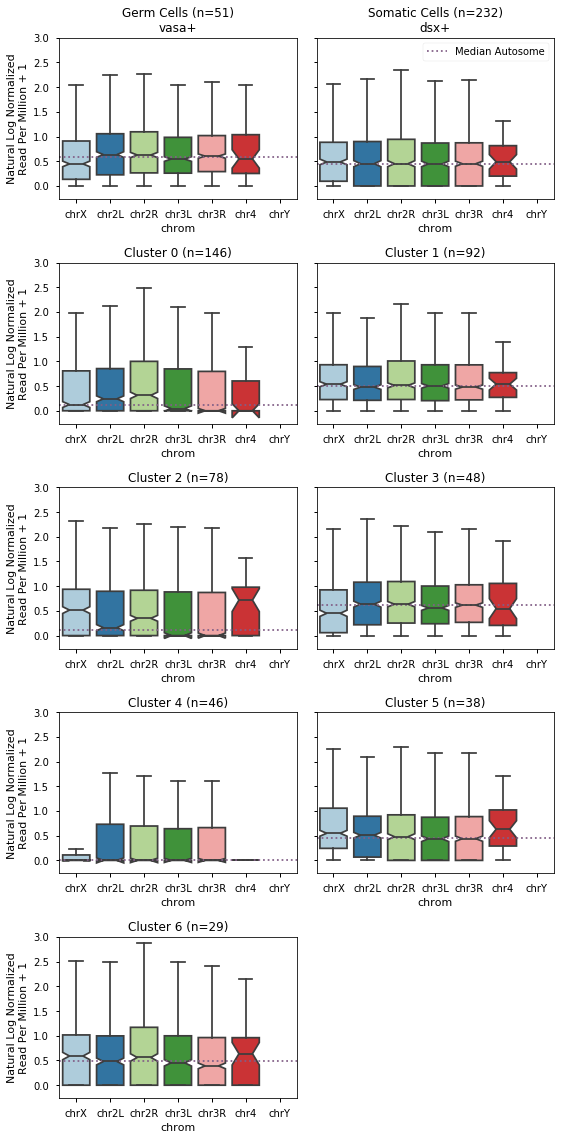

In [6]:
# Chromosome boxplots for different clusters
def plot_xtoa(df, ax, name):
    merged = df[expressed].join(fbgn2chrom).set_index('chrom', append=True)
    sns.boxplot(merged.index.get_level_values(-1), 
                merged.median(axis=1), notch=True, 
                ax=ax, order=CHROMS,  fliersize=0)
    ax.set_title(name)
    ax.set_ylim(None, 3)
    ax.axhline(merged.loc[
        (slice(None), AUTOSOMES), :
    ].median(axis=1).median(), ls=':', label='Median Autosome', color=nbconfig.color_c1)
    ax.set_ylabel('Natural Log Normalized\nRead Per Million + 1')

cls = [
    ('Germ Cells (n={})\nvasa+'.format(germ.shape[1]), germ),
    ('Somatic Cells (n={})\ndsx+'.format(soma.shape[1]), soma),
    ('Cluster 0 (n={})'.format(cluster0.shape[1]), cluster0),
    ('Cluster 1 (n={})'.format(cluster1.shape[1]), cluster1),
    ('Cluster 2 (n={})'.format(cluster2.shape[1]), cluster2),
    ('Cluster 3 (n={})'.format(cluster3.shape[1]), cluster3),
    ('Cluster 4 (n={})'.format(cluster4.shape[1]), cluster4),
    ('Cluster 5 (n={})'.format(cluster5.shape[1]), cluster5),
    ('Cluster 6 (n={})'.format(cluster6.shape[1]), cluster6),
]

# Make Boxplots
fig, axes = plt.subplots(5, 2, figsize=plt.figaspect(2)*2, sharey=True)
for (name, df), ax in zip(cls, axes.flatten()):
    plot_xtoa(df, ax, name)

for ax in axes[:, 1]:
    ax.set_ylabel('')
    
axes[0, 1].legend(loc=1)
axes[-1, -1].set_visible(False)
plt.tight_layout()

In [7]:
raw.head()

,AAACCTGGTTCATGGT,AAACGGGAGACTGGGT,AAACGGGGTGTTAAGA,AAAGATGAGTATCGAA,AAAGCAAGTCTAGGTT,AAATGCCGTAAAGGAG,AACCATGCAGTACACT,AACCGCGCAGCGTCCA,AACGTTGAGTACCGGA,AACTCAGAGAGTAATC,...,TTGGAACCAGTGGGAT,TTGGCAAGTTATTCTC,TTGGCAATCACAATGC,TTGGCAATCCTTCAAT,TTTATGCAGGAGTCTG,TTTATGCTCAACGCTA,TTTGGTTAGGTACTCT,TTTGGTTTCGTTGACA,TTTGTCAAGAGTAAGG,TTTGTCAAGCGTCAAG
FBgn0031081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0031085,2,0,0,0,0,0,0,0,0,0,...,6,0,0,0,0,109,1,0,1,0
FBgn0040784,3,0,0,0,24,0,0,0,0,0,...,0,0,18,0,0,97,0,0,0,2
FBgn0031086,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
FBgn0031082,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,20,0,0,0,0


In [8]:
cpm = np.log2(raw / raw.sum() * 1e4 + 0.05)

In [9]:
merged = fbgn2chrom.join(cpm[expressed]).set_index('chrom', append=True)

In [10]:
_autosomes = merged.loc[(slice(None), AUTOSOMES), :].reset_index(level='chrom').drop('chrom', axis=1).T
_x = merged.loc[(slice(None), 'chrX'), :].reset_index(level='chrom').drop('chrom', axis=1).T

In [11]:
_autoMean = _autosomes.join(clusters).groupby('ident').mean().T
_xMean = _x.join(clusters).groupby('ident').median().T

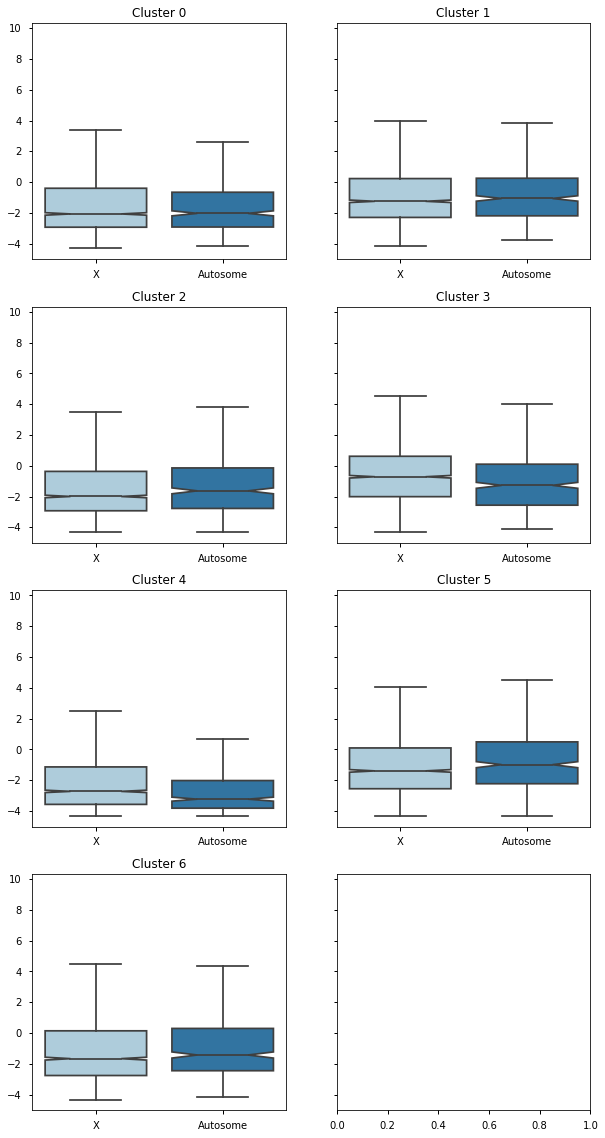

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20), sharey=True)
dfs = []
for ax, ((c, x), (c2, a)) in zip(axes.flatten(), 
                                 zip(_autosomes.join(clusters).groupby('ident'), 
                                     _x.join(clusters).groupby('ident'))):

    assert c == c2

    _xM = x.mean()
    _xM.name = 'X'
    _aM = a.mean()
    _aM.name = 'Autosome'

    df = pd.concat([_xM, _aM], axis=1)

    sns.boxplot(data=df, fliersize=0, ax=ax, notch=True)
    ax.set_title(f'Cluster {c:0.0f}');
    #ax.axhline(0, c='k', ls=':', label='Median Autosome')
    #ax.axhline(-np.log1p(2), ls='--', c='r', label='2-fold', alpha=.4)
    axes[0, 1].legend(loc='upper right')
    #ax.set_ylim(-4, 7)

In [13]:
def plot_box(df, **kwargs):
    _dat = df[clusters[clusters == 3].index].sum(axis=1).to_frame().join(fbgn2chrom).pivot(columns='chrom').iloc[:, 1:]
    _dat.columns = _dat.columns.droplevel()
    ax = sns.boxplot(data=_dat, **kwargs)
    return ax

(0, 500)

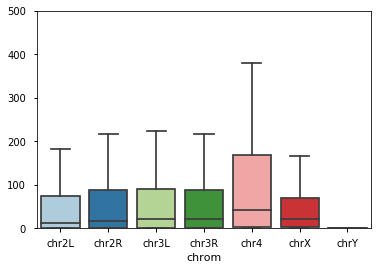

In [14]:
plot_box(raw, fliersize=0).set_ylim(0, 500)

(0, 200)

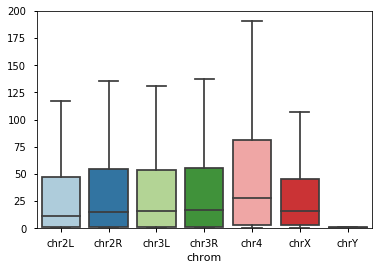

In [15]:
plot_box(np.log2(raw + 1), fliersize=0).set_ylim(0, 200)

(0, 100)

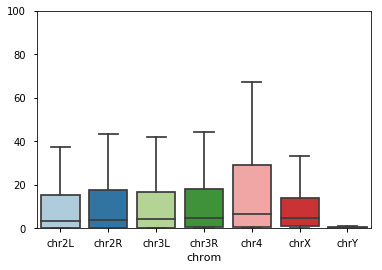

In [16]:
plot_box(norm, fliersize=0).set_ylim(0, 100)

In [17]:
plot_box(scaled)

NameError: name 'scaled' is not defined

In [72]:
BRIAN_FBGN = [symbol2fbgn[x] for x in BRIAN]
SHAR_PRIMARY_FBGN = [symbol2fbgn[x] for x in SHAR_PRIMARY]
SHAR_LATE_FBGN = [symbol2fbgn[x] for x in SHAR_LATE]
SHAR_POST_FBGN = [symbol2fbgn[x] for x in SHAR_POST]

In [56]:
def plot_scatter(A, B, A_label=None, B_label=None, highlight=None, annotate=False, title=None):
    _A = A.median(axis=1)
    _B = B.median(axis=1)
    _fbgns = _A.index.intersection(_B.index).tolist()

    _chrx = fbgn2chrom.loc[_fbgns, 'chrom'] == 'chrX'
    _autosome = fbgn2chrom.loc[_fbgns, 'chrom'].isin(CHROMS) & (fbgn2chrom.loc[_fbgns, 'chrom'] != 'chrX')
    
    plt.scatter(_A.loc[_autosome], _B.loc[_autosome], s=3, c='k', label='Autosomes')
    plt.scatter(_A.loc[_chrx], _B.loc[_chrx], s=8, c='r', label='X')
    ax = plt.gca()
    plt.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], c='r', alpha=.4)

    ax.set_xlabel(f'Cluster {A_label}\nLn Normalized Expression')
    ax.set_ylabel(f'Cluster {B_label}\nLn Normalized Expression')
    
    if highlight is None:
        pass
    else:
        _hi = [x for x in highlight if x in _fbgns]
        plt.scatter(_A.loc[_hi], _B.loc[_hi], s=50, marker='^', c='b', label='Highlighted Genes')
    
        if annotate:
            for pt in zip(zip(_A.loc[_hi].values, _B.loc[_hi].values), _hi):
                plt.annotate(fbgn2symbol[pt[1]], pt[0], xytext=(10,0), textcoords='offset points', fontsize=18)

    plt.legend()
    
    if title is not None:
        ax.set_title(title)

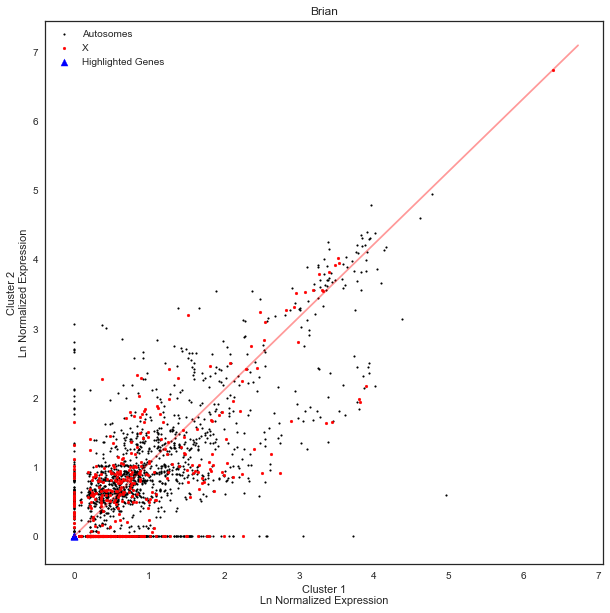

In [57]:
plot_scatter(cluster1, cluster2, 1, 2, BRIAN_FBGN, title='Brian')

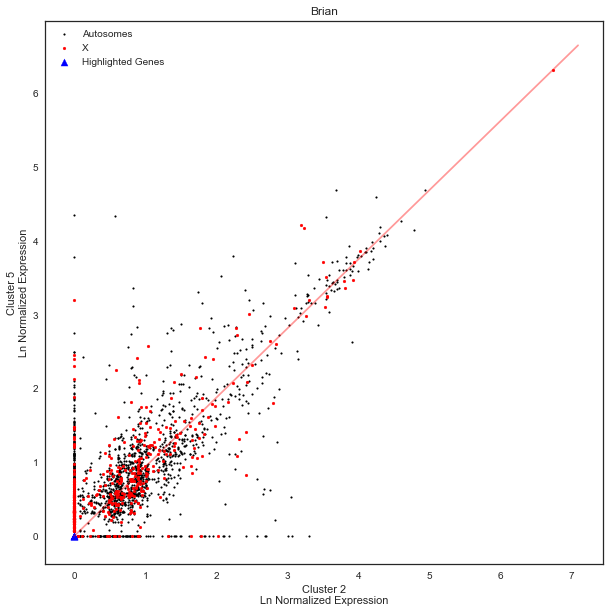

In [67]:
plot_scatter(cluster2, cluster5, 2, 5, BRIAN_FBGN, title='Brian')

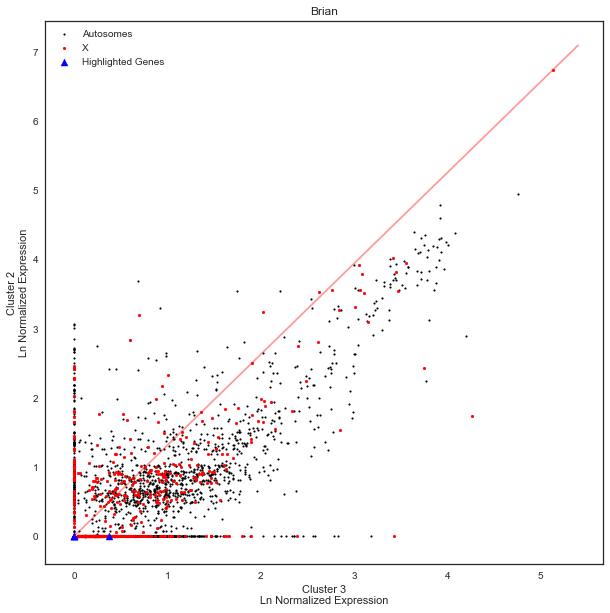

In [59]:
plot_scatter(cluster3, cluster2, 3, 2, BRIAN_FBGN, title='Brian')

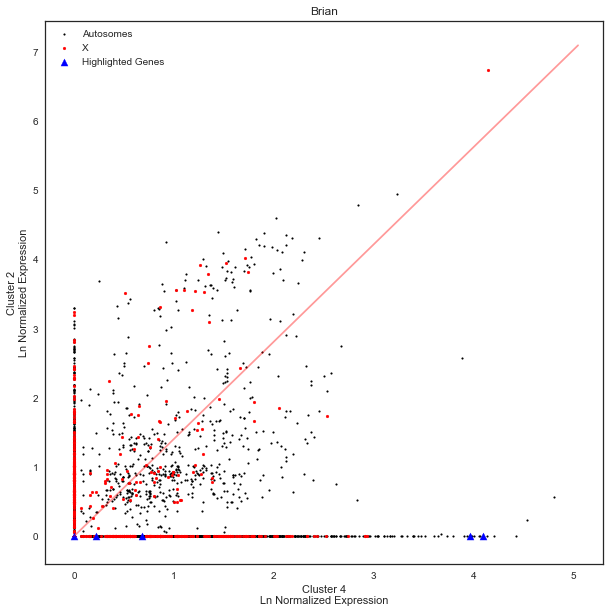

In [60]:
plot_scatter(cluster4, cluster2, 4, 2, BRIAN_FBGN, title='Brian')

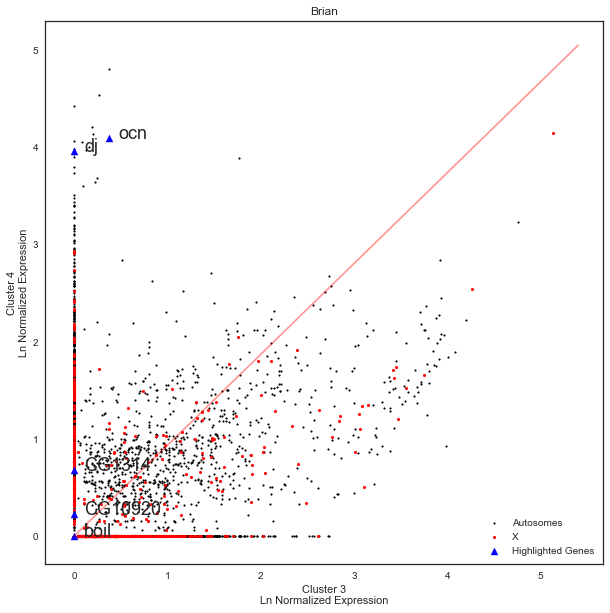

In [61]:
plot_scatter(cluster3, cluster4, 3, 4, BRIAN_FBGN, annotate=True, title='Brian')

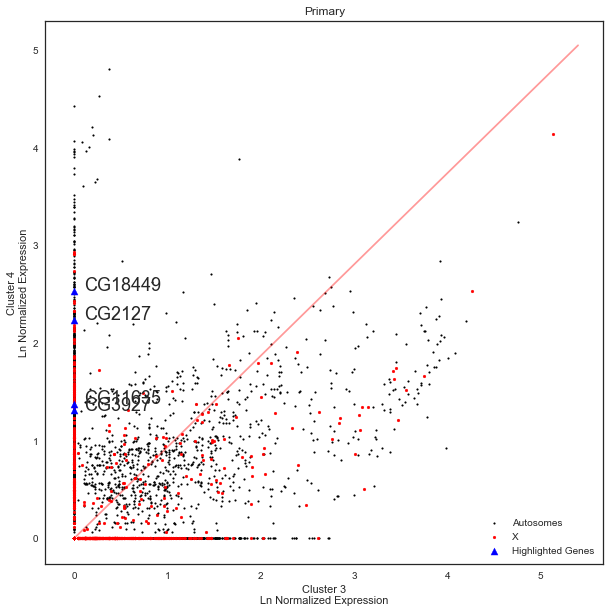

In [64]:
plot_scatter(cluster3, cluster4, 3, 4, SHAR_PRIMARY_FBGN, annotate=True, title='Primary')

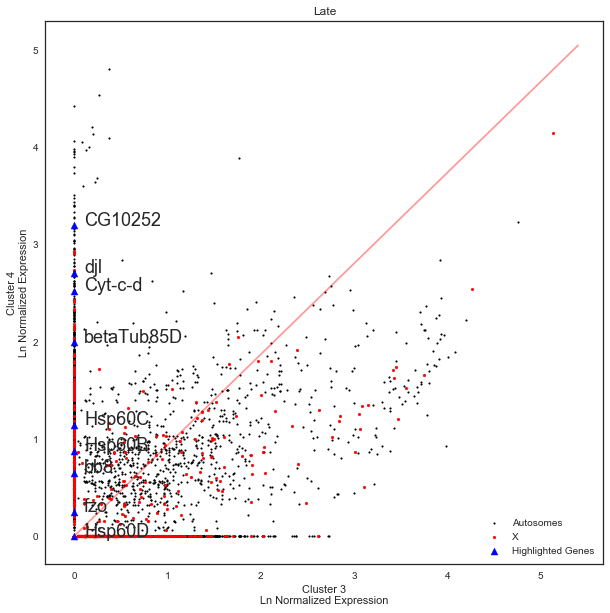

In [65]:
plot_scatter(cluster3, cluster4, 3, 4, SHAR_LATE_FBGN, annotate=True, title='Late')

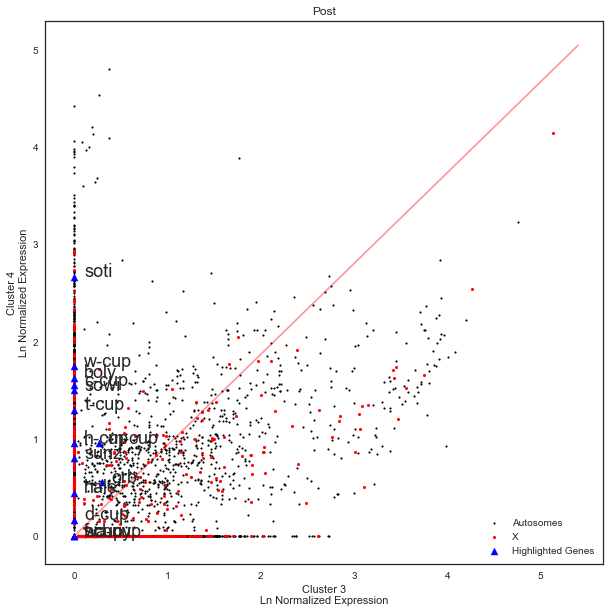

In [66]:
plot_scatter(cluster3, cluster4, 3, 4, SHAR_POST_FBGN, annotate=True, title='Post')

['14-3-3epsilon, 14-3-3zeta, ATPsynC, ATPsynD, ATPsynE',
 'ATPsynF, ATPsynO, ATPsynepsilonL, Act5C, Alg-2',
 'Atx2, CCT2, CG10674, CG11138, CG11267',
 'CG11505, CG12384, CG13096, CG13364, CG13540',
 'CG1416, CG14478, CG16817, CG17202, CG17514',
 'CG17650, CG2862, CG31715, CG32971, CG33774',
 'CG34200, CG42857, CG44303, CG44774, CG4502',
 'CG45050, CG5885, CG6770, CG6878, CG6937',
 'CG7518, CG8860, CG9669, CG9705, CG9821',
 'CG9922, CNBP, COX5A, COX6B, COX8',
 'CR43264, Cam, Capr, Cbp20, Cdc37',
 'CtBP, Cyp1, D1, ERp60, FK506-bp1',
 'FKBP59, Fib, Fis1, Fs(2)Ket, Gbeta13F',
 'HP6, His3.3A, His4r, HmgD, Hrb27C',
 'Hrb87F, Hsc70Cb, Hsp26, Hsp27, Hsp83',
 'IscU, Kap-alpha3, Lk6, MED26, MRE16',
 'Mapmodulin, Mnn1, ND-39, ND-ACP, ND-B12',
 'ND-B14.5B, ND-MWFE, Nap1, Nedd8, Nlp',
 'Nop56, Not1, Nph, Pfdn1, Pfdn5',
 'Prosalpha3, Prosalpha5, Prosalpha7, Prosbeta1, Prosbeta4',
 'Prosbeta5, Rad23, Ran, Rho1, RhoGAP71E',
 'Roc1a, RpL10, RpL10Ab, RpL11, RpL12',
 'RpL13, RpL13A, RpL14, RpL15, RpL17',

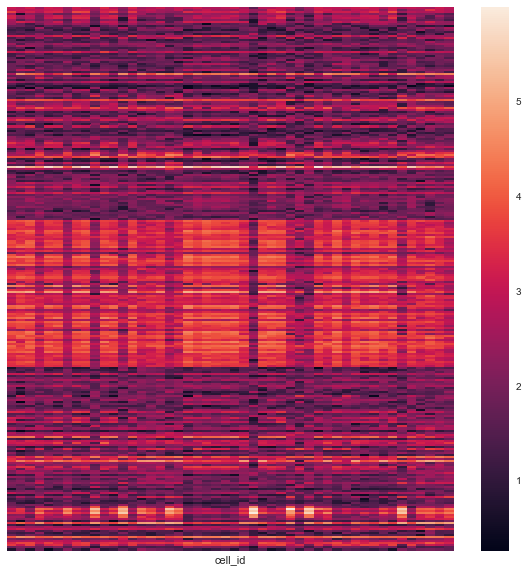

In [17]:
_CLUSTER = 3
clus = mergedNorm[mergedNorm.cluster == _CLUSTER].T.copy().drop('cluster')
clus = clus[(clus > 0).all(axis=1)].copy()
clus.index = clus.index.map(lambda x: fbgn2symbol[x])

fig, ax = plt.subplots(1, 1)
sns.heatmap(clus.sort_index(), ax=ax, yticklabels=False, xticklabels=False);

[', '.join(x) for x in grouper(clus.sort_index().index, 5)]

['ATPsynCF6L, ATPsynE, ATPsynF, Atg8b, BI-1, CG10252',
 'CG10317, CG10934, CG11106, CG11373, CG11562, CG11663',
 'CG12118, CG12307, CG12470, CG12689, CG12699, CG12853',
 'CG12860, CG12861, CG1324, CG13747, CG13898, CG1394',
 'CG14113, CG1418, CG14488, CG14658, CG14835, CG14995',
 'CG15034, CG15172, CG15177, CG15200, CG15219, CG15461',
 'CG15657, CG15742, CG16739, CG16817, CG17261, CG17376',
 'CG17377, CG17470, CG18449, CG18662, CG1958, CG1988',
 'CG2127, CG2291, CG30039, CG30065, CG30270, CG30324',
 'CG30369, CG30376, CG30430, CG30487, CG31007, CG31050',
 'CG31226, CG3124, CG31360, CG31468, CG31482, CG31639',
 'CG31709, CG31740, CG31788, CG31802, CG31820, CG31909',
 'CG31988, CG32148, CG32192, CG32267, CG32371, CG32450',
 'CG32727, CG33170, CG33189, CG33293, CG33308, CG33340',
 'CG34107, CG34168, CG34241, CG3687, CG42355, CG42393',
 'CG42523, CG42659, CG42688, CG42703, CG42758, CG43059',
 'CG43169, CG43209, CG43222, CG43277, CG43293, CG4375',
 'CG43922, CG43935, CG45490, CG45603, CG460

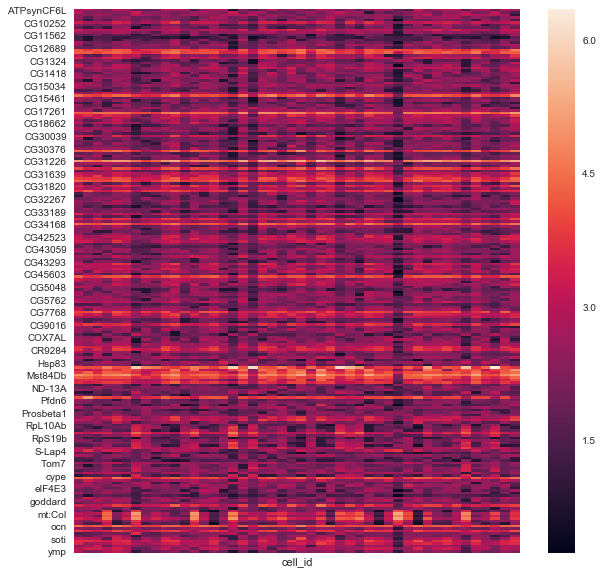

In [18]:
_CLUSTER = 4
clus = mergedNorm[mergedNorm.cluster == _CLUSTER].T.copy().drop('cluster')
clus = clus[(clus > 0).all(axis=1)].copy()
clus.index = clus.index.map(lambda x: fbgn2symbol[x])

fig, ax = plt.subplots(1, 1)
sns.heatmap(clus.sort_index(), ax=ax, xticklabels=False);

[', '.join(x) for x in grouper(clus.sort_index().index, 6)]

,gene_symbol,primary_FBgn,secondary_FBgn,annotation_ID,secondary_annotation_ID
0,d,FBgn0262029,"FBgn0032045,FBgn0086896,FBgn0000410,FBgn002597...",CG42840,"CG10595,CG13087,CG31610"
1,CG32532,FBgn0052532,"FBgn0031027,FBgn0031028,FBgn0031029",CG32532,"CG14203,CG14202,CG14201"
2,CG3156,FBgn0023536,NaN,CG3156,NaN
3,mRpL30,FBgn0029718,NaN,CG7038,NaN
4,CG1631,FBgn0031101,NaN,CG1631,NaN
